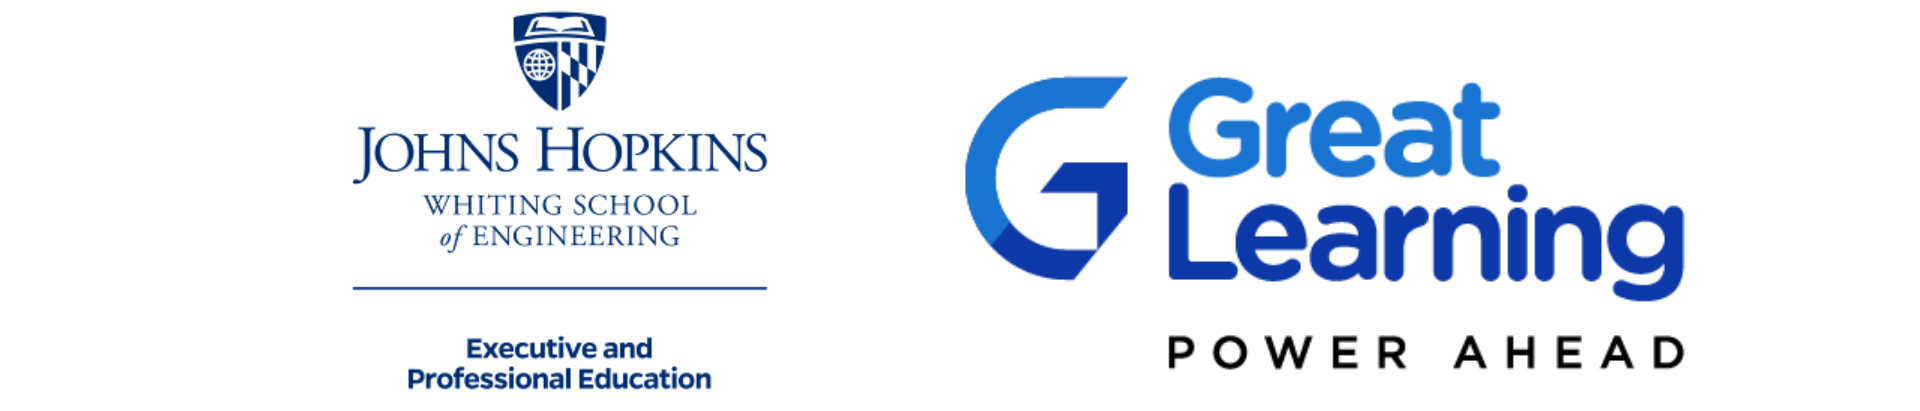

# **AI Research Synthesis Assistant - Agentic RAG**

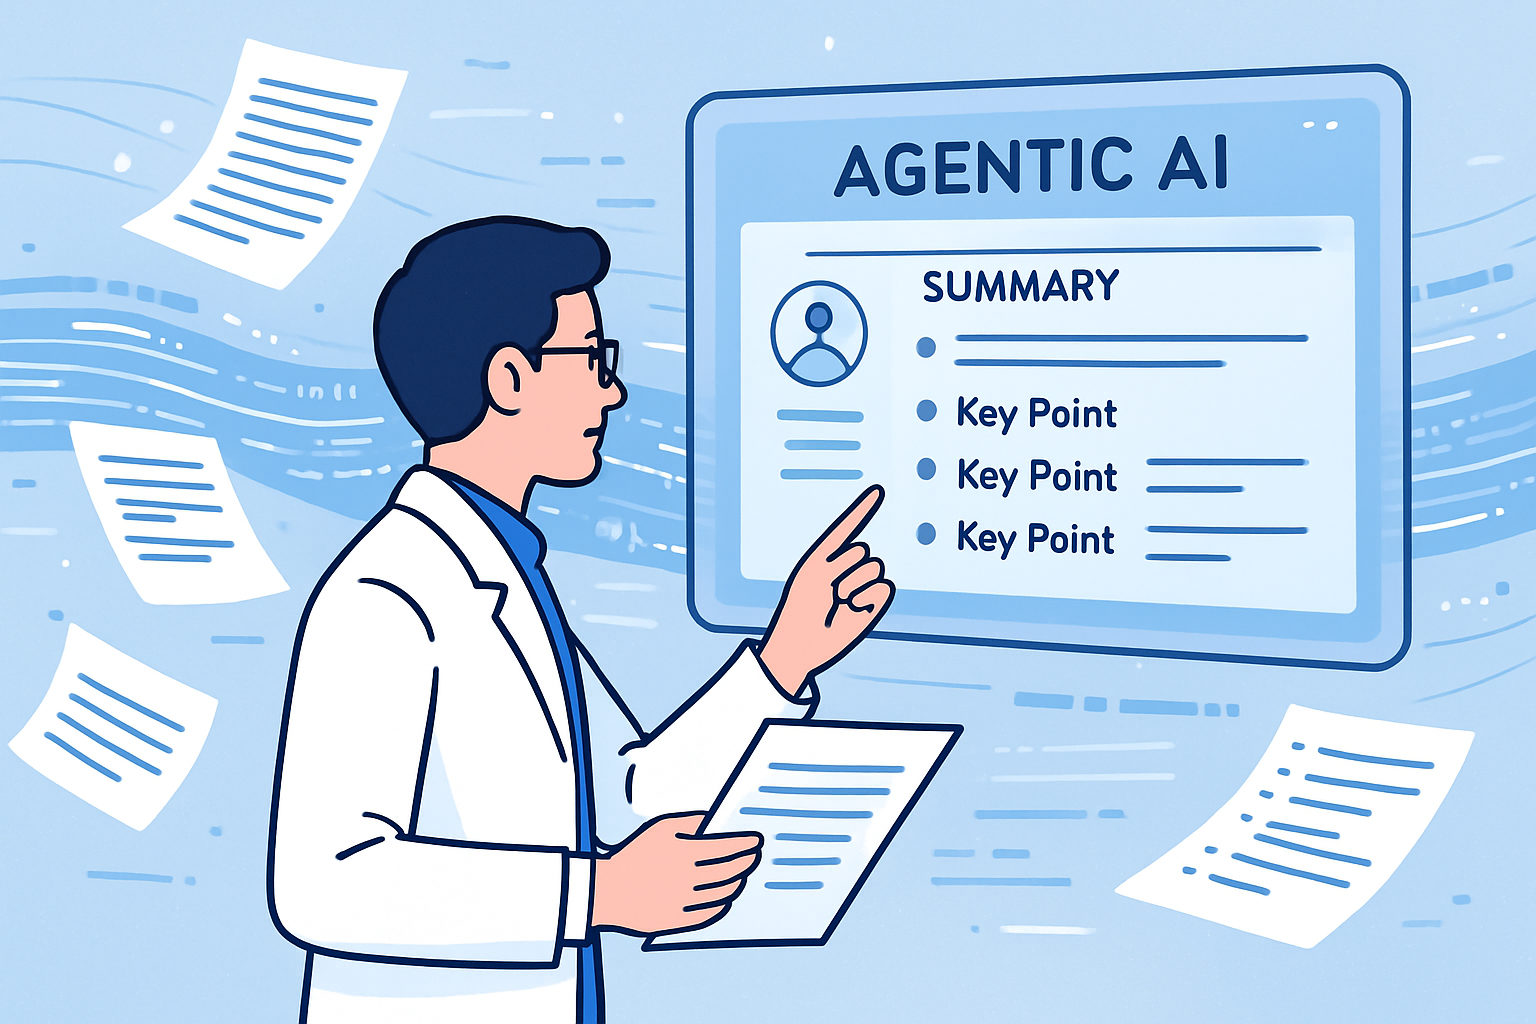

## **Problem Definition**

You are a researcher who is trying to explore the subject of Agentic AI by reading the research papers. You face the difficulty while determining which parts to prioritize and how to effectively extract meaningful information. To implement effective learning strategies, you decide to build an simple Agents which utilizes the **Retrieval as a Tool** (Agent having an RAG capabilities). This tool helps you analyze the papers by retrieving and summarizing key content, enabling you to synthesize knowledge from complex texts. Ultimately, it supports you in evaluating and focusing on the most important ideas/information without becoming overwhelmed by technical jargons.

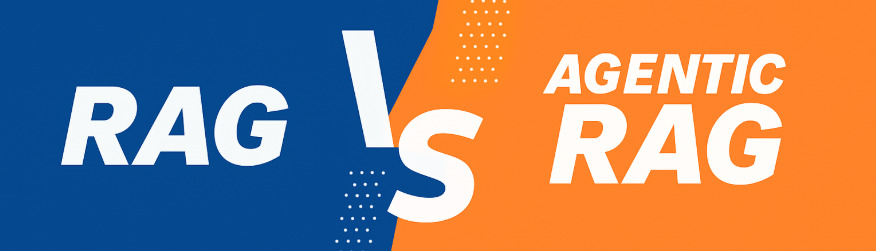

#### **Limitations of RAG**

1. ❌ Single Retrieval Step: If the initial retrieval results are poor, the final generation will suffer
2. ❌ Query-Document Mismatch: User queries (often questions) may not match well with documents containing answers (often statements)
3. ❌ Limited Reasoning: Simple RAG pipelines don’t allow for multi-step reasoning or query refinement
4. ❌ Context Window Constraints: Retrieved documents must fit within the model’s context window


#### **Benefits of Agentic RAG**
1. ✅ Formulate optimized queries: The agent can transform user questions into retrieval-friendly queries
2. ✅ Perform multiple retrievals: The agent can retrieve information iteratively as needed
3. ✅ Reason over retrieved content: The agent can analyze, synthesize, and draw conclusions from multiple sources
4. ✅ Self-critique and refine: The agent can evaluate retrieval results and adjust its approach

***Ref** - https://huggingface.co/docs/smolagents/en/examples/rag*

# **Setup**

In [ ]:
# @title Run this cell => Restart the session => Start executing the below cells **(DO NOT EXECUTE THIS CELL AGAIN)**

# -- Install other required packages with compatible versions --
!pip install smolagents==1.21.3 \
              pypdf==6.0.0 \
              langchain-community==0.3.29 \
              langchain-openai==0.3.32 \
              python-dotenv==1.1.1 \
              chromadb==1.0.20 \
              ddgs==9.5.5



  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached onnxruntime-1.22.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.9 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.37.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached bcrypt-4.3.0-cp39-abi3-manylinux_2_34_x86_64.whl.metadata (10 kB)
  Using cached kubernetes-33.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached mmh3-5.2.0-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_64.manylinux_2_5_x86_64.whl.metadata (14 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached durationpy-0.10-py3-none-any.whl.metadata (340 bytes)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached opentelemetry_exporter_otlp_proto_common-1.37.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached ope

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import tiktoken

import pandas as pd

from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma

# **LLM**

In [ ]:
#Loading the `config.json` file
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [ ]:
from smolagents import OpenAIServerModel
llm = OpenAIServerModel(
    model_id="gpt-4o-mini",
    api_base=os.environ['OPENAI_BASE_URL'],
    api_key=os.environ['OPENAI_API_KEY']
)

# **Implementing RAG**

## **1 - Loading the PDF, Chunking**

`agentic_ai_research_papers.zip` has 5 sample research papers on Agentic AI

In [ ]:
# Unzipping the Research Papers
import zipfile
with zipfile.ZipFile("/content/agentic_ai_research_papers.zip", 'r') as zip_ref:
  zip_ref.extractall("/content/")

In [ ]:
# Path of all reseach papers
research_paper_pdf_paths = [f"/content/agentic_ai_research_papers/{file}" for file in os.listdir("/content/agentic_ai_research_papers")]
research_paper_pdf_paths

['/content/agentic_ai_research_papers/The_role_of_agentic_AI_in_shaping_a_smart_future_A_systematic_review.pdf',
 '/content/agentic_ai_research_papers/AGI_via_Multi-Agent_Systems.pdf',
 '/content/agentic_ai_research_papers/AI_Agents_vs_Agentic_AI_A_Conceptual.pdf',
 '/content/agentic_ai_research_papers/Generative_to_Agentic_AI.pdf',
 '/content/agentic_ai_research_papers/AGENTIC_AI_FOR_SCIENTIFIC_DISCOVERY.pdf']

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader(path = "/content/agentic_ai_research_papers/")

Here we have used the `PyPDFDirectorLoader` because we are working with multiple documents in various files within a folder. It would then load each file, break it into chunks, and store these chunks in a list. This process involves looping over each file in the directory, chunking the file, and storing the chunks.

If it was for a single file in that case, we would use the `PyPDFLoader`.


In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=1000,
    chunk_overlap=200
)

In [ ]:
research_papers_chunks = loader.load_and_split(text_splitter)

(Note: Expect that the above cell may take time to execute).

In [ ]:
len(research_papers_chunks)

186

## **2 - Vector Store - ChromaDB, Embeddings**

In [ ]:
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model='text-embedding-ada-002')

In [ ]:
vectorstore = Chroma.from_documents(
    research_papers_chunks,
    embedding_model,
    collection_name="Research_Papers"
)

## **3 - Retriever as a Tool**

In [ ]:
from smolagents import Tool

class RetrieverTool(Tool):
    name = "retriever"
    description = "Leverages semantic search to retrieve the most contextually relevant sections from the documentation based on a user query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The search query to match against documentation. Phrase it as a natural language statement that reflects the kind of information you're seeking (e.g., 'How do I configure logging?')."
        }
    }
    output_type = "string"

    def __init__(self, vector_db, **kwargs):
        super().__init__(**kwargs)
        self.vector_db = vectorstore  # Save the vector database reference

    def forward(self, query: str) -> str:
        if not isinstance(query, str):
            raise ValueError("Query must be a string.")

        results = self.vector_db.similarity_search(query, k=10)  # Fetch top 10 similar documents
        formatted_docs = "\n".join(
            f"\n\n===== Document {i} =====\n{doc.page_content}" for i, doc in enumerate(results)
        )
        return f"\nRetrieved documents:\n{formatted_docs}"

retriever_tool = RetrieverTool(vector_db=vectorstore)

## **4 - Agent Definition & Calling**

In [ ]:
from smolagents import CodeAgent

agent = CodeAgent(
    tools=[retriever_tool],  # List of tools available to the agent
    model=llm,  # model "gpt-4o-mini"
    max_steps=6,  # Limit the number of reasoning steps
    verbosity_level=2,  # Show detailed agent reasoning
)

In [ ]:
# @title Test Question 1
print(agent.run("What are the key aspects of an Agentic AI systems?"))

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What are the key aspects of an Agentic AI systems?                                                              │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: To answer the question about the key aspects of Agentic AI systems, I will perform a retrieval of         
information that pertains specifically to this topic. I will use the `retriever` function with a query focused on  
Agentic AI systems to get the relevant details.                                                                    
                                                                                                                   
<code>                                                                                                             
key_aspects = retriever(query="key aspects of Agentic AI systems")                                                 
print(key_aspects)                                                                                                 
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  key_aspects = retriever(query="key aspects of Agentic AI systems")                                               
  print(key_aspects)                                                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

Retrieved documents:


===== Document 0 =====
delves into the concept of Agentic AI , discussing its fundamental prin -
ciples and impact on productivity, competitiveness, and innovation. 
Section 4 examines the hierarchical structure of Agentic AI systems, 
while Section 5 explores their business imperatives. The evolution of 
Agentic AI is discussed in Section 6 , followed by Section 7 , which covers 
its applications in outsourcing and AI services. Section 8 reviews the 
available tools and solutions that facilitate the development of Agentic 
AI. Section 9 outlines strategies for effectively leveraging Agentic AI 
while addressing its challenges. Finally, Section 10 presents conclusions 
and future research directions.
1.1. Agent-Based Artificial Intelligence (agentic AI)
Agentic AI refers to AI systems that exhibit autonomous decision- 
making, goal-oriented behavior, and continuous learning while 
interacting with dynamic environments. Unlike traditional AI, which 
often relies on human intervention or pre-programmed instructions, 
Agentic AI adapts based on real-time data and evolving objectives. These 
intelligent agents leverage machine learning, reinforcement learning, 
and multi-agent coordination to perform tasks efficiently [ 2 ].
1.1.1. Applications of agentic AI
• Energy : Optimizes energy consumption, predicts demand, and en -
hances the efficiency of renewable resources using historical data 
and weather conditions.
• Transportation : Improves route planning, reduces delivery times, 
and enhances supply chain logistics.
• Healthcare : Aids in medical diagnosis, personalized treatment 
plans, and patient data management.
• Finance : Analyzes market trends, assesses investment risks, and 
optimizes financial decision-making.
Agentic AI has the potential to revolutionize industries by offering 
improved decision-making capabilities, efficiency, and adaptability. 
However, its adoption must be accompanied by strategies to mitigate 
associated risks.
1.2. Key aspects of artificial intelligence
Despite its advantages, Agentic AI presents several challenges that 
must be addressed to ensure ethical and secure implementation. 
• Data Security & Privacy : AI systems process vast amounts of sen -
sitive data, making them vulnerable to breaches. Organizations must 
enforce stringent data protection policies and comply with legal 
frameworks [ 3 ].
• Ethical & Regulatory Concerns : Autonomous AI decisions can have 
unintended consequences, necessitating transparent AI governance 
models and ethical AI principles.
• Workforce Transformation : Automation raises concerns about job 
displacement, requiring proactive workforce reskilling initiatives 
and AI-human collaboration strategies.
To address these challenges, organizations must adopt the following 
strategies. 
• Employee Training : Upskilling programs to prepare employees for 
AI-integrated workflows.
• Robust AI Governance : Developing policies to ensure transparency, 
fairness, and accountability in AI decision-making.
• Regulatory Compliance : Aligning AI deployment with interna -
tional laws and ethical AI guidelines [ 4 , 5 ].
Fig. 1 is a visual representation of the core characteristics or capa -
bilities that define Agentic AI, presented as a central hub surrounded by 
six interconnected bubbles. The central circle, labeled “ Key aspects of 
Agentic AI, ” serves as the focal point, with arrows connecting it to the 
following six key aspects, arranged in a circular layout. 
1. Autonomy : This aspect highlights Agentic AI ’ s ability to operate 
independently, making decisions, and taking actions without direct 
human intervention. It reflects the system ’ s capacity to use planning, 
learning, and environmental data to perform complex tasks 
autonomously.
2. Goal-oriented behavior : This indicates that Agentic AI is designed 
to pursue specific objectives and optimize its actions to achieve 
desired outcomes, such as minimizing costs in transpor

[Step 1: Duration 3.49 seconds| Input tokens: 1,970 | Output tokens: 81]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: From the observation, I gathered comprehensive information about the key aspects of Agentic AI systems.   
Specifically, I noted that they encompass the following aspects:                                                   
                                                                                                                   
1. Autonomy: The ability to operate independently without direct human intervention.                               
2. Goal-oriented behavior: Designed to pursue specific objectives and optimize actions.                            
3. Environmental interaction: Ability to perceive and adapt to changes in surroundings.                            
4. Learning capability: Improvement of performance over time through machine learning.                             
5. Workflow optimization: Enhancing business processes through intelligent integration of tasks.                   
6. Multi-agent systems: Facilitating communication and collaboration among multiple agents.                        
                                                                                                                   
Now that I have identified these six key aspects, I will summarize this information and provide it as the answer to
the task.                                                                                                          
                                                                                                                   
<code>                                                                                                             
key_aspects_summary = {                                                                                            
    "1": "Autonomy: Ability to operate independently without human intervention.",                                 
    "2": "Goal-oriented behavior: Designed to pursue specific objectives.",                                        
    "3": "Environmental interaction: Adaptation to changes in surroundings.",                                      
    "4": "Learning capability: Improvement through machine learning.",                                             
    "5": "Workflow optimization: Enhanced business processes.",                                                    
    "6": "Multi-agent systems: Collaboration among multiple agents."                                               
}                                                                                                                  
final_answer(key_aspects_summary)                                                                                  
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  key_aspects_summary = {                                                                                          
      "1": "Autonomy: Ability to operate independently without human intervention.",                               
      "2": "Goal-oriented behavior: Designed to pursue specific objectives.",                                      
      "3": "Environmental interaction: Adaptation to changes in surroundings.",                                    
      "4": "Learning capability: Improvement through machine learning.",                                           
      "5": "Workflow optimization: Enhanced business processes.",                                                  
      "6": "Multi-agent systems: Collaboration among multiple agents."                                             
  }                                                                                                                
  final_answer(key_aspects_summary)                                                                                
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final answer: {'1': 'Autonomy: Ability to operate independently without human intervention.', '2': 'Goal-oriented 
behavior: Designed to pursue specific objectives.', '3': 'Environmental interaction: Adaptation to changes in 
surroundings.', '4': 'Learning capability: Improvement through machine learning.', '5': 'Workflow optimization: 
Enhanced business processes.', '6': 'Multi-agent systems: Collaboration among multiple agents.'}

[Step 2: Duration 11.37 seconds| Input tokens: 11,884 | Output tokens: 332]

{'1': 'Autonomy: Ability to operate independently without human intervention.', '2': 'Goal-oriented behavior: Designed to pursue specific objectives.', '3': 'Environmental interaction: Adaptation to changes in surroundings.', '4': 'Learning capability: Improvement through machine learning.', '5': 'Workflow optimization: Enhanced business processes.', '6': 'Multi-agent systems: Collaboration among multiple agents.'}


In [ ]:
# @title Test Question 2
agent.run("Give me the abstract for the paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions`")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Give me the abstract for the paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges,    │
│ and Future Directions`                                                                                          │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I will use the `retriever` tool to search for the abstract of the paper titled "Agentic AI for Scientific 
Discovery: A Survey of Progress, Challenges, and Future Directions." This tool will help me retrieve the relevant  
sections of the documentation or publication pertaining to the abstract of this specific paper.                    
                                                                                                                   
<code>                                                                                                             
abstract = retriever(query="Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future      
Directions abstract")                                                                                              
print(abstract)                                                                                                    
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  abstract = retriever(query="Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future    
  Directions abstract")                                                                                            
  print(abstract)                                                                                                  
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

Retrieved documents:


===== Document 0 =====
Published as a conference paper at ICLR 2025
AGENTIC AI FOR SCIENTIFIC DISCOVERY : A S URVEY
OF PROGRESS , C HALLENGES , AND FUTURE DIREC -
TIONS
Mourad Gridach, Jay Nanavati, Khaldoun Zine El Abidine, Lenon Mendes & Christina Mack
IQVIA
{firstname.lastname}@iqvia.com
ABSTRACT
The integration of Agentic AI into scientific discovery marks a new frontier in
research automation. These AI systems, capable of reasoning, planning, and au-
tonomous decision-making, are transforming how scientists perform literature re-
view, generate hypotheses, conduct experiments, and analyze results. This sur-
vey provides a comprehensive overview of Agentic AI for scientific discovery,
categorizing existing systems and tools, and highlighting recent progress across
fields such as chemistry, biology, and materials science. We discuss key evalua-
tion metrics, implementation frameworks, and commonly used datasets to offer a
detailed understanding of the current state of the field. Finally, we address criti-
cal challenges, such as literature review automation, system reliability, and ethical
concerns, while outlining future research directions that emphasize human-AI col-
laboration and enhanced system calibration.
1 I NTRODUCTION
The rapid advancements of Large Language Models (LLMs) (Touvron et al., 2023; Anil et al., 2023;
Achiam et al., 2023) have opened a new era in scientific discovery, with Agentic AI systems (Kim
et al., 2024; Guo et al., 2023; Wang et al., 2024; Abramovich et al., 2024) emerging as powerful
tools for automating complex research workflows. Unlike traditional AI, Agentic AI systems are
designed to operate with a high degree of autonomy, allowing them to independently perform tasks
such as hypothesis generation, literature review, experimental design, and data analysis. These
systems have the potential to significantly accelerate scientific research, reduce costs, and expand
access to advanced tools across various fields, including chemistry, biology, and materials science.
Recent efforts have demonstrated the potential of LLM-driven agents in supporting researchers
with tasks such as literature reviews, experimentation, and report writing. Prominent frameworks,
including LitSearch (Ajith et al., 2024), ResearchArena (Kang & Xiong, 2024), SciLitLLM (Li
et al., 2024c), CiteME (Press et al., 2024), ResearchAgent (Baek et al., 2024) and Agent Labora-
tory (Schmidgall et al., 2025), have made strides in automating general research workflows, such as
citation management, document discovery, and academic survey generation. However, these systems
often lack the domain-specific focus and compliance-driven rigor essential for fields like biomedical
domain, where the structured assessment of literature is critical for evidence synthesis. For example,
Agent Laboratory demonstrated high success rates in data preparation, experimentation, and report
writing. However, its performance dropped significantly in the literature review phase, reflecting the
inherent challenges of automating structured literature reviews. Moreover, questions about system
reliability, reproducibility, and ethical governance continue to pose significant hurdles.
This survey aims to provide a comprehensive review of Agentic AI for scientific discovery. We
categorize existing systems into autonomous and collaborative frameworks, detailing the datasets,
implementation tools, and evaluation metrics that support these innovations. By highlighting the
current state of the field and discussing open challenges, we hope to inspire further research and
development in Agentic AI, ultimately encouraging more reliable and impactful scientific contribu-
tions.
1
arXiv:2503.08979v1  [cs.CL]  12 Mar 2025


===== Document 1 =====
(2024); Xiao et al. (2024), software development Qian et al. (2024); White (2024) and healthcare
Tang et al. (2024); Kim et al. (2024). While multi-agent systems are powerful in solving difficu

[Step 1: Duration 4.31 seconds| Input tokens: 1,985 | Output tokens: 98]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I have retrieved the abstract of the paper successfully. The abstract outlines the significance of Agentic
AI in scientific discovery, emphasizing its capabilities in reasoning, planning, and autonomous decision-making. It
highlights the survey's aim to provide a comprehensive overview of Agentic AI systems, discussing their current    
state, challenges, and future directions.                                                                          
                                                                                                                   
Now, I will use the `final_answer` tool to present the abstract succinctly.                                        
                                                                                                                   
<code>                                                                                                             
final_answer("The integration of Agentic AI into scientific discovery marks a new frontier in research automation. 
These AI systems, capable of reasoning, planning, and autonomous decision-making, are transforming how scientists  
perform literature review, generate hypotheses, conduct experiments, and analyze results. This survey provides a   
comprehensive overview of Agentic AI for scientific discovery, categorizing existing systems and tools, and        
highlighting recent progress across fields such as chemistry, biology, and materials science. We discuss key       
evaluation metrics, implementation frameworks, and commonly used datasets to offer a detailed understanding of the 
current state of the field. Finally, we address critical challenges, such as literature review automation, system  
reliability, and ethical concerns, while outlining future research directions that emphasize human-AI collaboration
and enhanced system calibration.")                                                                                 
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The integration of Agentic AI into scientific discovery marks a new frontier in research           
  automation. These AI systems, capable of reasoning, planning, and autonomous decision-making, are transforming   
  how scientists perform literature review, generate hypotheses, conduct experiments, and analyze results. This    
  survey provides a comprehensive overview of Agentic AI for scientific discovery, categorizing existing systems   
  and tools, and highlighting recent progress across fields such as chemistry, biology, and materials science. We  
  discuss key evaluation metrics, implementation frameworks, and commonly used datasets to offer a detailed        
  understanding of the current state of the field. Finally, we address critical challenges, such as literature     
  review automation, system reliability, and ethical concerns, while outlining future research directions that     
  emphasize human-AI collaboration and enhanced system calibration.")                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final answer: The integration of Agentic AI into scientific discovery marks a new frontier in research automation. 
These AI systems, capable of reasoning, planning, and autonomous decision-making, are transforming how scientists 
perform literature review, generate hypotheses, conduct experiments, and analyze results. This survey provides a 
comprehensive overview of Agentic AI for scientific discovery, categorizing existing systems and tools, and 
highlighting recent progress across fields such as chemistry, biology, and materials science. We discuss key 
evaluation metrics, implementation frameworks, and commonly used datasets to offer a detailed understanding of the 
current state of the field. Finally, we address critical challenges, such as literature review automation, system 
reliability, and ethical concerns, while outlining future research directions that emphasize human-AI collaboration
and enhanced system calibration.

[Step 2: Duration 6.79 seconds| Input tokens: 11,681 | Output tokens: 341]

'The integration of Agentic AI into scientific discovery marks a new frontier in research automation. These AI systems, capable of reasoning, planning, and autonomous decision-making, are transforming how scientists perform literature review, generate hypotheses, conduct experiments, and analyze results. This survey provides a comprehensive overview of Agentic AI for scientific discovery, categorizing existing systems and tools, and highlighting recent progress across fields such as chemistry, biology, and materials science. We discuss key evaluation metrics, implementation frameworks, and commonly used datasets to offer a detailed understanding of the current state of the field. Finally, we address critical challenges, such as literature review automation, system reliability, and ethical concerns, while outlining future research directions that emphasize human-AI collaboration and enhanced system calibration.'

In [ ]:
# @title Test Question 3
print(agent.run("List down the authors of the research paper - `Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, and Future Directions` "))

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ List down the authors of the research paper - `Agentic AI for Scientific Discovery: A Survey of Progress,       │
│ Challenges, and Future Directions`                                                                              │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I need to search for the research paper titled "Agentic AI for Scientific Discovery: A Survey of Progress,
Challenges, and Future Directions" to find its authors. I will use the `retriever` function with a relevant query  
to obtain this information.                                                                                        
                                                                                                                   
<code>                                                                                                             
authors = retriever(query="List down the authors of the research paper 'Agentic AI for Scientific Discovery: A     
Survey of Progress, Challenges, and Future Directions'")                                                           
print(authors)                                                                                                     
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  authors = retriever(query="List down the authors of the research paper 'Agentic AI for Scientific Discovery: A   
  Survey of Progress, Challenges, and Future Directions'")                                                         
  print(authors)                                                                                                   
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

Retrieved documents:


===== Document 0 =====
Published as a conference paper at ICLR 2025
AGENTIC AI FOR SCIENTIFIC DISCOVERY : A S URVEY
OF PROGRESS , C HALLENGES , AND FUTURE DIREC -
TIONS
Mourad Gridach, Jay Nanavati, Khaldoun Zine El Abidine, Lenon Mendes & Christina Mack
IQVIA
{firstname.lastname}@iqvia.com
ABSTRACT
The integration of Agentic AI into scientific discovery marks a new frontier in
research automation. These AI systems, capable of reasoning, planning, and au-
tonomous decision-making, are transforming how scientists perform literature re-
view, generate hypotheses, conduct experiments, and analyze results. This sur-
vey provides a comprehensive overview of Agentic AI for scientific discovery,
categorizing existing systems and tools, and highlighting recent progress across
fields such as chemistry, biology, and materials science. We discuss key evalua-
tion metrics, implementation frameworks, and commonly used datasets to offer a
detailed understanding of the current state of the field. Finally, we address criti-
cal challenges, such as literature review automation, system reliability, and ethical
concerns, while outlining future research directions that emphasize human-AI col-
laboration and enhanced system calibration.
1 I NTRODUCTION
The rapid advancements of Large Language Models (LLMs) (Touvron et al., 2023; Anil et al., 2023;
Achiam et al., 2023) have opened a new era in scientific discovery, with Agentic AI systems (Kim
et al., 2024; Guo et al., 2023; Wang et al., 2024; Abramovich et al., 2024) emerging as powerful
tools for automating complex research workflows. Unlike traditional AI, Agentic AI systems are
designed to operate with a high degree of autonomy, allowing them to independently perform tasks
such as hypothesis generation, literature review, experimental design, and data analysis. These
systems have the potential to significantly accelerate scientific research, reduce costs, and expand
access to advanced tools across various fields, including chemistry, biology, and materials science.
Recent efforts have demonstrated the potential of LLM-driven agents in supporting researchers
with tasks such as literature reviews, experimentation, and report writing. Prominent frameworks,
including LitSearch (Ajith et al., 2024), ResearchArena (Kang & Xiong, 2024), SciLitLLM (Li
et al., 2024c), CiteME (Press et al., 2024), ResearchAgent (Baek et al., 2024) and Agent Labora-
tory (Schmidgall et al., 2025), have made strides in automating general research workflows, such as
citation management, document discovery, and academic survey generation. However, these systems
often lack the domain-specific focus and compliance-driven rigor essential for fields like biomedical
domain, where the structured assessment of literature is critical for evidence synthesis. For example,
Agent Laboratory demonstrated high success rates in data preparation, experimentation, and report
writing. However, its performance dropped significantly in the literature review phase, reflecting the
inherent challenges of automating structured literature reviews. Moreover, questions about system
reliability, reproducibility, and ethical governance continue to pose significant hurdles.
This survey aims to provide a comprehensive review of Agentic AI for scientific discovery. We
categorize existing systems into autonomous and collaborative frameworks, detailing the datasets,
implementation tools, and evaluation metrics that support these innovations. By highlighting the
current state of the field and discussing open challenges, we hope to inspire further research and
development in Agentic AI, ultimately encouraging more reliable and impactful scientific contribu-
tions.
1
arXiv:2503.08979v1  [cs.CL]  12 Mar 2025


===== Document 1 =====
Agentic AI are intended to be accessible to a wide audience, while recent innovations
in Agentic AI are tailored for a more technically focused readership. To this end, we
adopt a high-level ca

[Step 1: Duration 4.75 seconds| Input tokens: 1,987 | Output tokens: 96]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: The authors of the research paper "Agentic AI for Scientific Discovery: A Survey of Progress, Challenges, 
and Future Directions" have been retrieved from the observation. They are: Mourad Gridach, Jay Nanavati, Khaldoun  
Zine El Abidine, Lenon Mendes, and Christina Mack. I will format this information as a list to present the final   
answer.                                                                                                            
                                                                                                                   
<code>                                                                                                             
authors_list = ["Mourad Gridach", "Jay Nanavati", "Khaldoun Zine El Abidine", "Lenon Mendes", "Christina Mack"]    
final_answer(authors_list)                                                                                         
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  authors_list = ["Mourad Gridach", "Jay Nanavati", "Khaldoun Zine El Abidine", "Lenon Mendes", "Christina Mack"]  
  final_answer(authors_list)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final answer: ['Mourad Gridach', 'Jay Nanavati', 'Khaldoun Zine El Abidine', 'Lenon Mendes', 'Christina Mack']

[Step 2: Duration 4.37 seconds| Input tokens: 11,709 | Output tokens: 220]

['Mourad Gridach', 'Jay Nanavati', 'Khaldoun Zine El Abidine', 'Lenon Mendes', 'Christina Mack']


In [ ]:
# @title Test Question 4
print(agent.run("What can be the evaluation metrics for the Agentic AI systems?"))

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ What can be the evaluation metrics for the Agentic AI systems?                                                  │
│                                                                                                                 │
╰─ OpenAIServerModel - gpt-4o-mini ───────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: To answer the question regarding the evaluation metrics for Agentic AI systems, I will search for relevant
information by querying specific phrases related to evaluation metrics in AI systems. I will likely need to        
leverage the `retriever` tool to find sections from the documentation that specifically cover metrics used for     
evaluating Agentic AI systems.                                                                                     
                                                                                                                   
<code>                                                                                                             
metrics_info = retriever(query="evaluation metrics for Agentic AI systems")                                        
print(metrics_info)                                                                                                
                                                                                                                   

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  metrics_info = retriever(query="evaluation metrics for Agentic AI systems")                                      
  print(metrics_info)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

Retrieved documents:


===== Document 0 =====
(2024) employs multiple workers handling parts of a task (sequentially) and a
manager aggregating results.
• Learning: Agents may learn independently in decentralized systems or share
experiences centrally to accelerate collective improvement.
• Communication content: Communication is primarily text-based; coopera-
tive systems often package instructions, goals, state descriptions, action histories,
and dialogue histories into messages (Zhang et al., 2023). Agentic systems often
mimic real-world development by featuring domain-expert agents that collaborate
through discussions, potentially adopting varied communication styles (Yamamoto
et al., 2025).
3.5.3 Evaluating Agentic AI
Evaluating Agentic AI is challenging. Agents can behave non-deterministic with com-
plex interactions and require a much longer time-span to complete tasks than GenAI.
Agents can exhibit a wide range of capabilities and desiderata that require evaluation.
We outline key decision domains but refer readers to specialized surveys for further
details (Yehudai et al., 2025). Capabilities span general LLM skills like long-text
understanding and instruction following, as well as agent-specific skills such as plan-
ning, learning from interactions, error handling, tool usage, and spatial reasoning (Wu
et al., 2023). Desiderata include task performance (Wu et al., 2023), failure aware-
ness (recognizing impending failure), efficient tool usage, harmfulness (Andriushchenko
et al., 2024), and computational efficiency—for instance, ARC Prize Foundation
(2025) enforced efficiency by setting computational limits for tasks. Beyond founda-
tional capabilities, agents can also be evaluated on domain-specific competencies. For
instance, evaluating agents simulating humans in user studies has involved manual
comparisons with real users and sanity checks that vary names and gender to account
for prompt sensitivity and model shortcomings (Aher et al., 2023).
Metrics can include generic measures such as completion rate (fraction of tasks com-
pleted) or task success rate (Wang et al., 2023), possibly supplemented by solution
quality scores, self-aware failure rates (fraction of tasks where agents signal failure
before failing), and tool call accuracy. In games, evaluation scores could reflect devi-
ations from optimal actions (e.g., in rock-paper-scissors) or achievements awarded by
the game engine (Wu et al., 2023).
Benchmarks designed for Generative AI, such as the well-known MMLU bench-
mark (Hendrycks et al., 2021b), can also be applied to Agentic AI; MMLU has been
extended with more complex questions to better evaluate reasoning abilities (Wang
et al., 2024). Various datasets exist for evaluating (or training) Agentic AI, often
focusing on specific areas such as tool usage (over 14,000 REST APIs (Qin et al.,
2023)), robot learning (Walke et al., 2023), assistant-user task pairs (Li et al., 2023),
programming (Hendrycks et al., 2021a), social game playing (Akata et al., 2023), and
simulating human behavior in user studies (Aher et al., 2023). Frameworks are also
available to facilitate task evaluation. Lin et al. (2023) offers infrastructure enabling
researchers to easily design custom evaluation tasks. Games are frequently used for
evaluation, ranging from simple games like rock-paper-scissors to complex environ-
ments like Minecraft (Wu et al., 2023). Several benchmarks target evaluating agents
31


===== Document 1 =====
Published as a conference paper at ICLR 2025
6.3 M ETRICS
Metrics in this field are diverse, depending on the specific task and domain. For reasoning and
planning, metrics typically assess accuracy, task completion rates, and response coherence. In ex-
perimental prediction and scientific discovery, metrics like precision, recall, and prediction error
are used to evaluate the quality and reliability of AI-generated results. Explainability and human
evaluation also play a critical role in a

[Step 1: Duration 3.30 seconds| Input tokens: 1,971 | Output tokens: 89]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: From the retrieved documents, I have found a variety of evaluation metrics proposed for Agentic AI        
systems. These metrics include completion rates, task success rates, tool usage efficiency, self-aware failure     
rates, among others. Specific metrics highlighted in the documents include:                                        
                                                                                                                   
1. **Completion Rate**: The fraction of tasks completed by the agent.                                              
2. **Task Success Rate**: The percentage of tasks successfully completed.                                          
3. **Solution Quality Scores**: Evaluations based on the quality of solutions generated.                           
4. **Self-aware Failure Rate**: The rate at which agents can recognize and signal impending failures before they   
occur.                                                                                                             
5. **Tool Call Accuracy**: The accuracy of using external tools or APIs during task execution.                     
6. **Usability Metrics**: Measures such as user satisfaction, utility, and continuation rates.                     
7. **Causal Reasoning and Prediction Accuracy**: Evaluation of a system's ability to understand cause and effect   
and make accurate predictions.                                                                                     
8. **Explainability and Human Evaluation**: How comprehensible and acceptable the outputs of AI systems are to     
human users.                                                                                                       
9. **Benchmarks**: Such as MMLU, used to assess reasoning capabilities through complex question answering.         
                                                                                                                   
I will summarize these evaluation metrics concisely.                                                               
                                                                                                                   
<code>                                                                                                             
evaluation_metrics = [                                                                                             
    "Completion Rate: fraction of tasks completed",                                                                
    "Tas

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  evaluation_metrics = [                                                                                           
      "Completion Rate: fraction of tasks completed",                                                              
      "Task Success Rate: percentage of tasks successfully completed",                                             
      "Solution Quality Scores: evaluations based on quality of solutions",                                        
      "Self-aware Failure Rate: rate of recognizing impending failures",                                           
      "Tool Call Accuracy: accuracy in using external tools or APIs",                                              
      "Usability Metrics: user satisfaction, utility, and continuation rates",                                     
      "Causal Reasoning and Prediction Accuracy: ability for cause-and-effect understanding",                      
      "Explainability and Human Evaluation: comprehensibility and acceptability of outputs",                       
      "Benchmarks: like MMLU for assessing reasoning capabilities"                                                 
  ]                                                                                                                
                                                                                                                   
  final_answer(evaluation_metrics)                                                                                 
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Final answer: ['Completion Rate: fraction of tasks completed', 'Task Success Rate: percentage of tasks successfully
completed', 'Solution Quality Scores: evaluations based on quality of solutions', 'Self-aware Failure Rate: rate of
recognizing impending failures', 'Tool Call Accuracy: accuracy in using external tools or APIs', 'Usability 
Metrics: user satisfaction, utility, and continuation rates', 'Causal Reasoning and Prediction Accuracy: ability 
for cause-and-effect understanding', 'Explainability and Human Evaluation: comprehensibility and acceptability of 
outputs', 'Benchmarks: like MMLU for assessing reasoning capabilities']

[Step 2: Duration 10.36 seconds| Input tokens: 12,353 | Output tokens: 483]

['Completion Rate: fraction of tasks completed', 'Task Success Rate: percentage of tasks successfully completed', 'Solution Quality Scores: evaluations based on quality of solutions', 'Self-aware Failure Rate: rate of recognizing impending failures', 'Tool Call Accuracy: accuracy in using external tools or APIs', 'Usability Metrics: user satisfaction, utility, and continuation rates', 'Causal Reasoning and Prediction Accuracy: ability for cause-and-effect understanding', 'Explainability and Human Evaluation: comprehensibility and acceptability of outputs', 'Benchmarks: like MMLU for assessing reasoning capabilities']


# **Conclusion**
- In this notebook, we have learned how to create and use the Retrieval as a Tool for an AI Agents, which can perform Q&A on research papers for quicker, more efficient, and accurate information retrieval.
- By combining the reasoning capabilities of LLM agents with the factual grounding of retrieval systems, we can build more powerful, flexible, and accurate information systems.